In [61]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
autoreload 2

In [57]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
from tqdm import tqdm as tqdm
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from utils import DEVICE

Handle Data

In [4]:
valid_size = 0.1
batch_size = 32
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = torchvision.datasets.MNIST(
                root='../data', 
                train=True,
                download=True, 
                transform=transform)

test_data = torchvision.datasets.MNIST(
                root='../data', 
                train=False,
                download=True, 
                transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=2)

valid_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    sampler=valid_sampler, 
                    num_workers=2)

test_loader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=batch_size,
                    num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
 #          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = range(10)

Processing...
Done!


(32, 1, 28, 28)


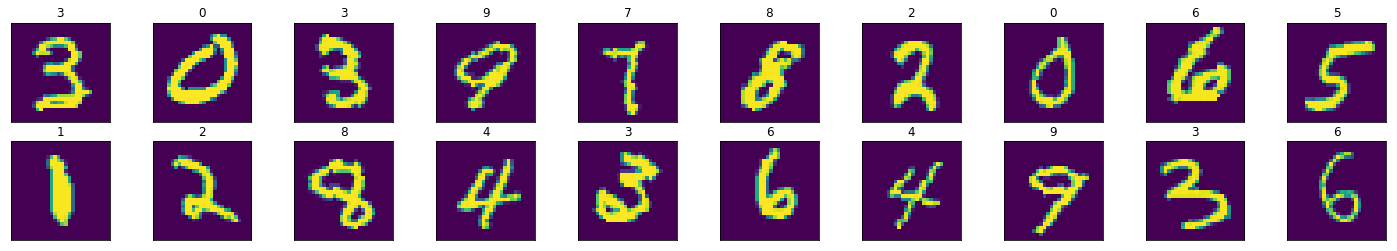

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

    # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0])
    ax.set_title(classes[labels[idx]])

# Define Training functions

## Define how to train a frequentist model

In [39]:
def accuracy(outputs, labels, batch_size = batch_size):
    _, preds = outputs.max(1)
    correct = torch.eq(preds, labels).sum().item()
    return correct/len(labels)

In [40]:
def test(model):
    test_accs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            test_accs.append(accuracy(outputs, labels))
    print('\nTest Accuracy: {:.2f} %'.format(100*np.mean(test_accs)))

In [41]:
def train(name, model, writer, n_epochs = 100):
    print('\nTraining Model ', name)
    optimizer = optim.Adam(model.parameters())
    xent = nn.CrossEntropyLoss()
    model.train()
    m = len(train_loader)
    for epoch in range(n_epochs):
        history = dict(train_acc = [],
                      val_acc = [],
                      xent = [])
        epoch_data = []
        
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            history['train_acc'].append(accuracy(outputs, labels))
            loss = xent(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['xent'].append(loss.item())
            print('\rEpoch {0}/{1} \t Batch {2}/{3} \t Cross Entropy: {4}, Train Accuracy: {5}%'.format(
                epoch+1, n_epochs, batch_id, m, history['xent'][-1], 100*history['train_acc'][-1]), end = '')
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # tensorboard values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                             np.mean(values), epoch+1)
        
        epoch_data.append({key:np.mean(values) for key, values in history.items()})
    pd.DataFrame(epoch_data).to_csv('results/MNIST_{0}.csv'.format(name, n_epochs))
    return model

## Define how to train a Bayesian Model

In [42]:
def bayes_train(name, model, writer, n_epochs = 100, n_samples = 2):
    model.train()
    m = len(train_loader)
    
    for epoch in range(n_epochs):
        history = dict(train_acc = [],
                       val_acc = [],
                       kl = [],
                       xent = [])
        epoch_data = []
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            beta = 2 ** (m - (batch_id + 1)) / (2 ** m - 1)
            #beta = 1/m
            
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = [model(images) for _ in range(n_samples)]
            kl, xe, loss = model.step(outputs, labels, beta)
            
            history['train_acc'].append(accuracy(outputs[0], labels))
            history['kl'].append(kl.item()/len(labels))
            history['xent'].append(xe.item()/len(labels))
            print('\rEpoch {0}/{1} \t Batch {2}/{3} \t Cross Entropy: {4}, Train Accuracy: {5}%'.format(
                epoch+1, n_epochs, batch_id, m, history['xent'][-1], 100*history['train_acc'][-1]), end = '')
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # Save values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                                 np.mean(values), epoch+1)
        epoch_data.append({key:np.mean(values) for key, values in history.items()})
    pd.DataFrame(epoch_data).to_csv('results/MNIST_{0}.csv'.format(name, n_epochs))
    return model

# Define and Train Models

In [43]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
N_EPOCHS = 2

CRITICAL:root:Cannot load caffe2.python. Error: /opt/caffe2/build/caffe2/python/caffe2_pybind11_state.so: undefined symbol: _ZN5fLI6438FLAGS_caffe2_max_keep_on_shrink_memoryE


## Frequentist mlp

In [46]:
from utils import Flatten
mlp = lambda n_hidden: nn.Sequential(Flatten(28*28),
            nn.Linear(28*28, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, 10))

mlp_net = train('MLP 100', mlp(100).to(DEVICE), writer, n_epochs = N_EPOCHS)

test(mlp_net)


Training Model  MLP 100
Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.08827237039804459, Train Accuracy: 93.75%
Test Accuracy: 95.17 %


In [29]:
import models

alexnet = train('AlexNet', models.AlexNet(1, 10).to(DEVICE), writer, n_epochs = N_EPOCHS)
test(alexnet)

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.007626354694366455, Train Accuracy: 50.0%
Test Accuracy: 97.07 %


## Bayesian MLP

In [30]:
from utils import ScaleMixtureGaussian
from bayes import BayesWrapper

prior_nll = ScaleMixtureGaussian(PI = 0.75,
                                 SIGMA_1 = np.exp(-1),
                                 SIGMA_2 = np.exp(-6))

In [31]:
bayesnet = BayesWrapper(name='BayesMLP 100',
                        net=mlp(100).to(DEVICE),
                        prior_nll = prior_nll)
bayes_train('Bayes MLP 100', bayesnet, writer, n_epochs = N_EPOCHS, n_samples =2)
test(bayesnet)

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.007733482867479324, Train Accuracy: 46.875%
Test Accuracy: 94.72 %


In [32]:
bayesalexnet = BayesWrapper(name='BayesAlexNet',
                        net=models.AlexNet(1, 10).to(DEVICE),
                        prior_nll = prior_nll)
bayes_train('Bayes AlexNet 100', bayesalexnet , writer, n_epochs = N_EPOCHS, n_samples =2)
test(bayesalexnet)

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.0013395422138273716, Train Accuracy: 50.0%
Test Accuracy: 96.71 %


In [55]:
writer.add_scalar('1', 1, 1)
writer.scalar_dict

{}

In [60]:
pd.DataFrame([dict(a=1, b=2),dict(a=2, b=3)]).to_csv('test.csv')

Test